# Curso Análisis de Redes

## Cátedra Teoría de las Telecomunicaciones - Universidad ORT Uruguay



# Teoría de Colas (2a. Parte)

In [1]:
#using Pkg;Pkg.instantiate(); Pkg.update()

## Sistemas de fila de espera

Nos interesa modelar sistemas de *eventos discretos* en los cuales:

* Hay un arribo de "trabajos" o "clientes" a cierta tasa $\lambda$ de manera estocástica.
* Los clientes son puestos en una o varias *filas de espera* (colas).
* Cada trabajo es atendido por uno o múltiples *servidores* a cierta *tasa*.
* Al terminar su servicio, el trabajo deja el sistema.

### Diagrama

![Sistema](../images/sistema.png "Sistema")

## Sistemas con servidores en paralelo

Nos interesa empezar a estudiar los sistemas con múltiples servidores trabajando en paralelo, y en general una única cola de espera.

Para comenzar a modelar este tipo de sistemas, sirve tener primero como paradigma el *sistema de infinitos servidores* (infinite server queue) o cola $M/M/\infty$.

> **Definición:** Una cola $M/M/\infty$ es un sistema al cual:
>
> * Llegan trabajos como un proceso de Poisson de intensidad $\lambda$.
> * Cada trabajo requiere un tiempo de servicio exponencial de parámetro $\mu$.
> * Existen infinitos servidores disponibles: al llegar un nuevo trabajo, se le asigna inmediatamente uno libre (nunca hay cola).

### Cola $M/M/\infty$ - diagrama:

![Cola M/M/Inf](../images/mminf.png "Cola M/M/Inf")

Definamos:

$$X(t) = \text{no. de clientes en el sistema en tiempo } t.$$

Notemos que $X$ en este caso coincide con la cantidad de servidores ocupados.

### Modelo Markoviano de la cola $M/M/\infty$:

Observemos que:

* $X(t)$ toma valores en $E=\{0,1,2,\ldots\}$.
* Si $X=0$, entonces el sistema espera un tiempo exponencial de parámetro $\lambda$ a que llegue el primer cliente.
* Si $X=1$, entonces la transición es la primera de dos posibilidades:
   * Al cabo de una $\exp(\lambda)$, llegará un nuevo cliente $X\to 2$.
   * Al cabo de una $\exp(\mu)$, el cliente en servicio deja el sistema $X\to 0$.
* Si $X=2$, entonces la transición es la primera de *tres* posibilidades:
   * Al cabo de una $\exp(\lambda)$, llegará un nuevo cliente $X\to X+1$.
   * Al cabo de una $\exp(\mu)$, el primer cliente en servicio deja el sistema $X\to X-1$.
   * Al cabo de una $\exp(\mu)$, el segundo cliente en servicio deja el sistema $X\to X-1$.

Razonando análogamente para cada estado, puede verse que en el estado $k$ hay $k$ exponenciales de parámetro $\mu$ compitiendo para producir una transición $k\to k-1$, lo que sugiere el modelo:

![Cadena M/M/Inf](../images/mminf_markov.png "Cadena de la cola M/M/Inf")

### Cálculo del estado estacionario.

Dado el modelo, es fácil ver que si $\lambda.\mu>0$ es irreducible. Podemos intentar calcular $\pi$, la distribución estacionaria del sistema. Para ello, podemos usar las ecuaciones de balance global, o bien, por un truco similar al visto para el paseo al azar con barrera, plantear únicamente *balance local*:

Las ecuaciones son:

$$\begin{align} \pi_0 \lambda &= \pi_1\mu \\ \pi_1 \lambda &= \pi_2 2\mu \\ \pi_2 \lambda &= \pi_3 3\mu \\ \cdots& \\ \pi_{k-1} \lambda &= \pi_k k\mu \\ \cdots& \end{align}$$

De donde, definiendo el parámetro de *carga* $\rho=\lambda/\mu$:

$$\pi_k = \pi_{k-1} \frac{\rho}{k} = \pi_{k-2}\frac{\rho^2}{k(k-1)} = \cdots = \pi_0 \frac{\rho^k}{k!}.$$

Es decir, sugiere una distribución Poisson para $\pi_k$.

### Distribución en régimen

Imponiendo que $\sum_k \pi_k =1$ obtenemos:

$$1 = \sum_{k=0}^\infty \pi_0 \frac{\rho^k}{k!} = \pi_0 e^\rho.$$

De donde el sistema es ergódico o estable *para todo $\rho$* y $\pi_0 = e^{-\rho}$.

En ese caso:

$$\pi_k = e^{-\rho} \frac{\rho^k}{k!} \quad k=0,1,2,\ldots$$

Es decir $X\sim Poisson(\rho)$ en régimen.

### Simulación

In [2]:
using Distributions

function simula_MMinf(lambda,mu,x0,Tfinal)
    
    d1 = Exponential(1/lambda)
    d2 = Exponential(1/mu)
    
    x=x0
    t=0.0
    
    T=[t]
    X=[x]
    
    arribos = Int64[]
    partidas = Int64[]
    
    i=1
    
    while t<Tfinal
    
        i=i+1
        if x>0
            t1 = rand(d1)  #tiempo para subir
            t2 = minimum(rand(d2,x))  #tiempo para bajar, el minimo de x exponenciales mu.
            #t2 = rand(Exponential(1/(x*mu)))  #esta es otra forma equivalente
            
            if t1<t2    #gana subir
                x=x+1
                t=t+t1
                push!(arribos,i)
            else        #gana bajar
                x=x-1
                t=t+t2
                push!(partidas,i)
            end

        else    
            t=t+rand(d1) #en 0 solo subo
            x=x+1
            push!(arribos,i)
        end
        
        push!(T,t)
        push!(X,x)
        
        
    end

    return T,X,arribos, partidas
end

simula_MMinf (generic function with 1 method)

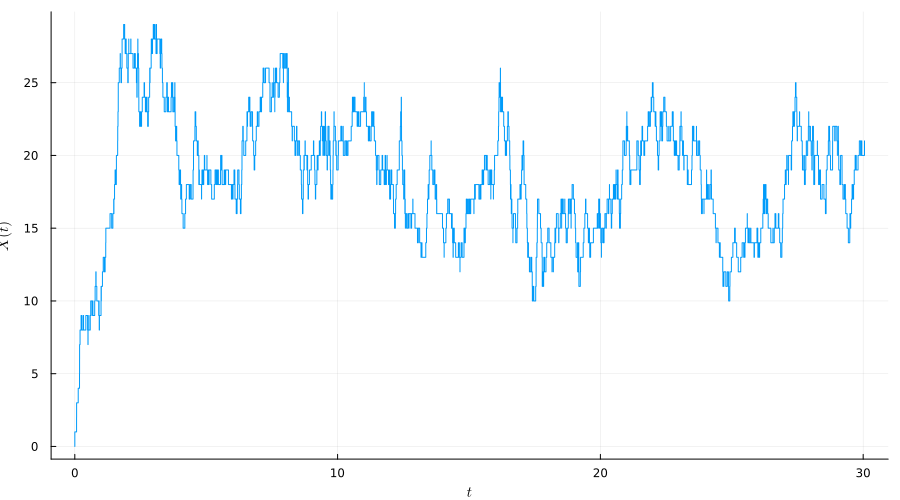

In [3]:
using Plots, LaTeXStrings
default(size=(900,500), legendfontsize=10, labelfontsize=10)

lambda = 20.0
mu = 1.0
Tfinal = 30

T,X,arribos,salidas = simula_MMinf(lambda,mu,0,Tfinal)

plot(T,X,lt=:steppost,xlabel=L"t", ylabel=L"X(t)", label=:none)

### Ocupación Media del Sistema

Calculemos $\bar{X} = E[X(t)]$ en régimen.

$$\begin{align}
E[X(t)] &= \sum_{k=0}^\infty k e^{-\rho}\frac{\rho^k}{k!} = \rho e^{-\rho}\sum_{k=1}^\infty \frac{\rho^{k-1}}{(k-1)!} \\
&= \rho e^{-\rho} e^\rho\\
&= \rho
\end{align}$$

Es decir, aquí $\rho$ tiene la interpretación de cuántos trabajos/servidores se ocupan en media.

In [4]:
rho = lambda/mu
Xbar_teo = rho
Xbar = sum(X[1:end-1].*diff(T))/T[end]

println("X medio empírico: $Xbar, X medio teórico: $Xbar_teo")

X medio empírico: 18.40041821001835, X medio teórico: 20.0


### Retardo de un cliente

Notemos que en este caso, al no haber cola, el retardo de un cliente es simplemente su servicio, por lo tanto:

$$\bar{W} = \frac{1}{\mu}.$$

Observemos además que se verifica nuevamente la ley de Little:

$$\bar{X} = \rho = \lambda \frac{1}{\mu} = \lambda \bar{W}.$$


**Observación:** si bien en el código anterior guardamos los arribos y las partidas, **no** se puede hallar el retardo simplemente restando porque los clientes *no tienen por qué salir en el mismo orden de llegada*.

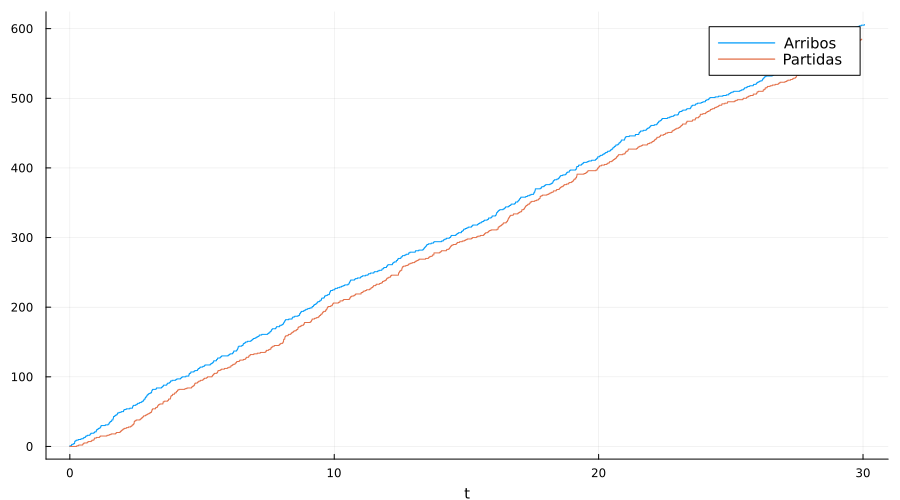

In [5]:
Na = length(arribos)
Ns = length(salidas)

Tarribos = T[arribos]
Tsalidas = T[salidas]

plot([0;Tarribos], (0:Na), lt=:steppost, label="Arribos", xlabel="t")
plot!([0;Tsalidas], (0:Ns), lt=:steppost, label="Partidas")

### Tasa de salida de trabajos

La tasa de salida de trabajos es la pendiente en régimen de la curva roja anterior, la frecuencia con la que observamos salir un cliente del sistema.

Si el sistema está en $X=k$, entonces la tasa de salida es $r_k=k\mu$ de donde la tasa media es:

$$\bar{r} = \sum_k \pi_k r_k = \sum_{k=0}^\infty \pi_k k\mu = \mu \bar{X} = \lambda.$$

Por lo tanto, la tasa de salida es igual a la de entrada (razonable, porque el sistema opera de forma estable).

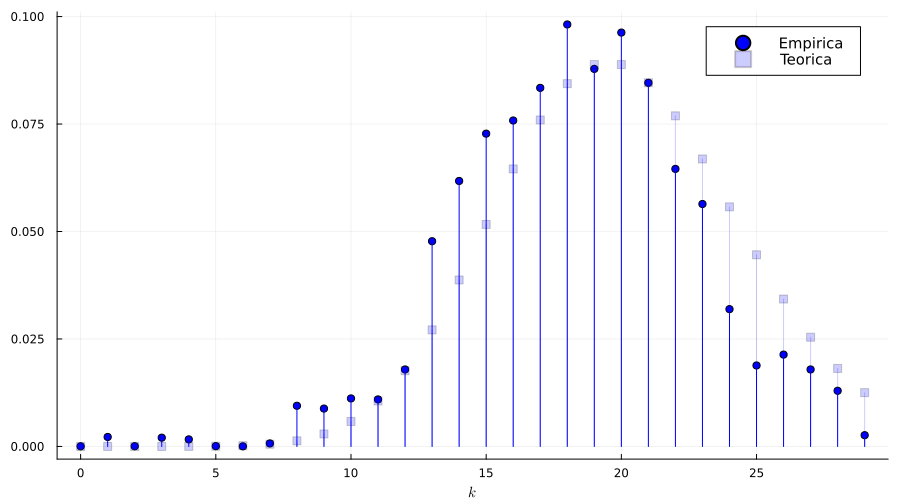

In [6]:
function ocupacion_empirica(T,X)
    
    kmax = maximum(X)
    
    k = (0:kmax)
    
    #aplico la misma funcion a cada j en k (comando map)
    p = map(j->sum((X[1:end-1].==j).*diff(T))/T[end],k)
    
    return k,p
end

k,p = ocupacion_empirica(T,X)

plot(k,p, lt=:stem, marker=:circle, color=:blue, label="Empirica", xlabel=L"k")
plot!(k,pdf.(Poisson(rho),k), lt=:stem, marker=:square, alpha=0.2, color=:blue, label="Teorica")

### Aplicación:

Considere el estacionamiento de un centro comercial. Los lugares de estacionamiento son los "servidores", y cada cliente llega de manera independiente al azar. Si el estacionamiento es suficientemente grande, podemos hacer una aproximación de que hay infinitos espacios.

* Supongamos que los clientes llegan como un proc. de Poisson de intensidad $\lambda$.
* Identifiquemos con $1/\mu$ la duración media de la visita (tiempo que el "servidor" está ocupado).

En ese caso, el no. de lugares ocupados en régimen es $X\sim Poisson(\rho)$. Utilizando la aproximación Normal a la Poisson:

$$Poisson(\rho) \approx N(\rho,\rho),$$

tenemos que entonces habrá menos de $\rho + z_\alpha \sqrt{\rho}$ lugares ocupados una proporción $\alpha$ del tiempo, siendo $z_\alpha$ el cuantil de la gaussiana (ej: $z_{0.05} = 1.64$).

**Conclusión:** debemos "cubrirnos" en una cantidad de orden $\sqrt{\rho}$ (por ejemplo $2\sqrt{\rho}$) y casi nunca veremos el estacionamiento lleno.

### Ejemplo $\rho=100$:

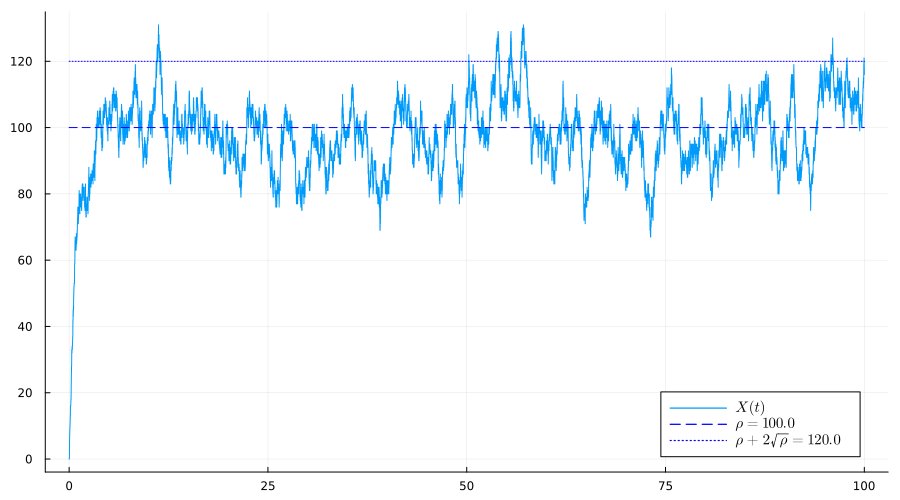

In [7]:
lambda=100.0
mu=1.0
Tfinal=100.0
rho=lambda/mu

T,X = simula_MMinf(lambda,mu,0,Tfinal)

plot(T,X, lt=:steppost, label=L"X(t)", legend=:bottomright)
plot!(T,rho*(ones(size(T))), ls=:dash, color=:blue, label=L"\rho = %$rho")
plot!(T,(rho+2*sqrt(rho))*(ones(size(T))), ls=:dot, color=:blue, label=L"\rho+2\sqrt{\rho} = %$(rho+2sqrt(rho))")

## Sistema de múltiples servidores

Hasta ahora vimos dos modelos: el sistema de servidor único y cola de espera, y el sistema de infinitos servidores en paralelo y sin cola. ¿Cuál es el punto medio entre estos sistemas?

Consideremos un sistema que tiene una cantidad *fija* $m$ de servidores y una *unica* cola de espera:

> **Definición:** Una cola $M/M/m$ es un sistema al cual:
>
> * Llegan trabajos como un proceso de Poisson de intensidad $\lambda$.
> * Cada trabajo requiere un tiempo de servicio exponencial de parámetro $\mu$.
> * Existen $m$ servidores disponibles: al llegar un nuevo trabajo, se le asigna inmediatamente uno libre. Si todos están ocupados, se encola el trabajo.

### Cola $M/M/m$ - diagrama:

![Cola M/M/m](../images/mmm.png "Cola M/M/m")

### Modelo Markoviano de la cola $M/M/m$:

Definamos:

$$X(t) = \text{no. de clientes en el sistema en tiempo } t.$$

Observemos que:

* $X(t)$ toma valores en $E=\{0,1,2,\ldots\}$.
* Los arribos son a tasa $\lambda$ constante.
* Si $X(t) = k < m$, la tasa de servicio neta de todos los trabajos es $k\mu$ ya que solo hay $k$ servidores ocupados.
* Si $X(t) = k \geqslant m$, la tasa de servicio neta de todos los trabajos es $m\mu$ ya ahora se ocuparon todos los servidores

### Diagrama de estados

![Cadena M/M/m](../images/mmm_markov.png "Cadena de la cola M/M/m")

### Simulación

In [8]:
using Distributions

function simula_MMm(lambda,mu,m,x0,Tfinal)
    
    d1 = Exponential(1/lambda)
    d2 = Exponential(1/mu)
    
    x=x0
    t=0.0
    
    T=[t]
    X=[x]
        
    while t<Tfinal
    
        i=i+1
        if x>0
            t1 = rand(d1)  #tiempo para subir
            t2 = minimum(rand(d2,min(x,m)))  #tiempo para bajar, el minimo de min(x,m) exponenciales mu.
        
            if t1<t2    #gana subir
                x=x+1
                t=t+t1
            else        #gana bajar
                x=x-1
                t=t+t2
            end

        else    
            t=t+rand(d1) #en 0 solo subo
            x=x+1
        end
        
        push!(T,t)
        push!(X,x)
        
    end

    return T,X
end

simula_MMm (generic function with 1 method)

In [9]:
lambda = 9.0
mu = 1.0
m=10

Tfinal = 50

T,X = simula_MMm(lambda,mu,m,0,Tfinal)

plot(T,X,lt=:steppost,xlabel=L"t", ylabel=L"X(t)", label=:none)

LoadError: UndefVarError: i not defined

### Carga del sistema

Claramente, cuando el sistema acumula muchos trabajos, es necesario que $\lambda < m\mu$ para volver a llevarlo a la zona estable.

Esto sugiere definir la *carga del sistema* en una cola $M/M/m$ como:

$$\rho = \frac{\lambda}{m\mu}.$$

La condición de estabilidad debería ser entonces $\rho<1$. Verifiquemos esto con las ecuciones de balance.

### Ecuaciones de balance

* Si $k\leqslant m$, las ecuaciones de balance local son *exactamente iguales* a las de la $M/M/\infty$, por lo que:

$$\pi_k = \pi_0 \frac{(\lambda/\mu)^k}{k!} = \pi_0 \frac{(m\rho)^k}{k!} \quad k=0,\ldots,m.$$

* A partir de $k=m$, la tasa de servicio queda fija (satura), por lo que:

$$\pi_k = \pi_m \left(\frac{\lambda}{m\mu}\right)^{k-m} = \pi_m \rho^{k-m}, \quad k\geqslant m.$$

Sustituyendo $\pi_m$ en la última expresión y combinando queda:

$$\pi_k = \begin{cases}
\pi_0 \frac{(m\rho)^k}{k!} \quad k=0,\ldots,m \\
\pi_0 \frac{(m\rho)^m}{m!} \rho^{k-m}\quad k=m,m+1,\ldots
\end{cases}
$$

### Condición de estabilidad y distribución de régimen

Imponiendo $\sum_k \pi_k = 1$ se llega a:

$$1 = \sum_{k=0}^\infty \pi_k = \pi_0 \left[\sum_{k=0}^{m-1} \frac{(m\rho)^k}{k!} + \sum_{k=m}^\infty \frac{(m\rho)^m}{m!} \rho^{k-m}\right].$$

De las dos sumatorias, la primera siempre es finita por lo que no presenta problemas. La segunda es una geométrica de razón $\rho$ por lo que, si $\rho<1$ tenemos:

$$\sum_{k=m}^\infty \frac{(m\rho)^m}{m!} \rho^{k-m} = \frac{(m\rho)^m}{m!} \sum_{j=0}^\infty \rho^j = \frac{(m\rho)^m}{m!}  \frac{1}{1-\rho}$$.

Sustituyendo lo anterior tenemos finalmente que:

$$\pi_0 = \frac{1}{\sum_{k=0}^{m-1} \frac{(m\rho)^k}{k!} + \frac{(m\rho)^m}{m!} \frac{1}{1-\rho}}.$$

In [10]:
function equilibrio_mmm(kmax,rho,m)

    #kmax=vector de valores donde evaluar, debe incluir a m para que funcione
    @assert rho<1 "La carga debe ser menor a 1"
    @assert kmax>=m "kmax debe incluir a m"
    
    pi = zeros(kmax+1)
    
    pi[1] = 1.0
    
    for i=1:m
        pi[i+1] = pi[i]*m*rho/i
    end
    
    sum1 = sum(pi[1:m]) #primera sumatoria del pi0
    
    sum2 = pi[m+1]*(1/(1-rho))
    
    pi = pi/(sum1+sum2) #normalizo
    
    for i=m+1:kmax
        pi[i+1] =pi[i] * rho
    end
    
    return pi
    
    
end

equilibrio_mmm (generic function with 1 method)

ρ = 0.9


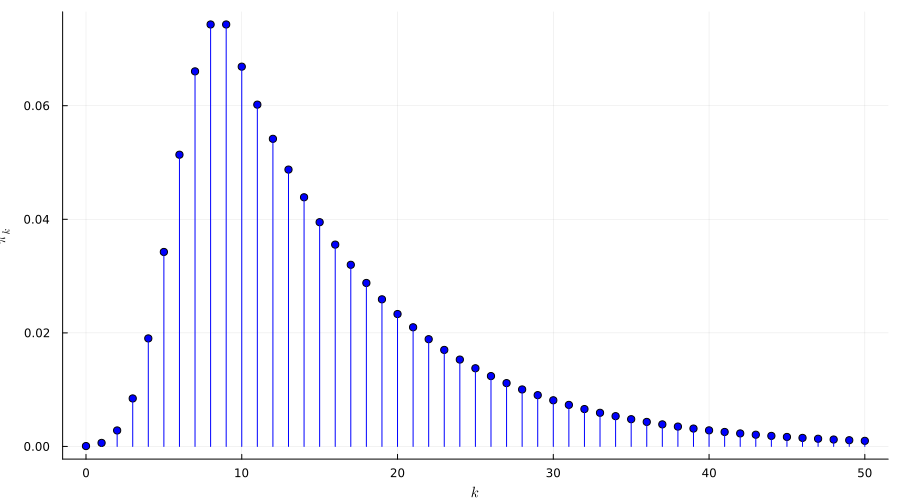

In [11]:
kmax=50
lambda=9.0
mu=1.0
m=10

rho=lambda/(mu*m)
println("ρ = $rho")
plot((0:kmax),equilibrio_mmm(kmax,rho,m),lt=:stem, marker=:circle, color=:blue, label=:none, ylabel=L"\pi_k", xlabel=L"k")

In [12]:
lambda=9.0
mu=1.0
m=10
Tfinal=2000

T,X = simula_MMm(lambda,mu,m,0,Tfinal)
k,p = ocupacion_empirica(T,X)

rho=lambda/(mu*m)
println("ρ = $rho")
plot(k,p, lt=:stem, marker=:circle, color=:blue, label="Empirica")
plot!((0:kmax),equilibrio_mmm(kmax,rho,m),lt=:stem, marker=:circle, color=:blue, alpha=0.4, label="Teorica", xlabel=L"k")

LoadError: UndefVarError: i not defined

In [13]:
##Ocupacion media teorica y empirica
Xbar_teo = sum( (0:kmax).*equilibrio_mmm(kmax,lambda/(mu*m),m) )
Xbar = sum( X[1:end-1].*diff(T)/T[end] )

println("Ocupacion media teórica (calculada numericamente): $Xbar_teo")
println("Ocupacion media empírica: $Xbar")
        

Ocupacion media teórica (calculada numericamente): 14.484823828606793
Ocupacion media empírica: 97.35036391868756


### Cálculo del retardo

Aunque no tenemos fórmula para $\bar{X}$, usando la aproximación numérica anterior podemos estimar el retardo del sistema mediante la Ley de Little:

$$\bar{X} = \lambda \bar{W}$$

In [14]:
retardo_teo = Xbar_teo/lambda

println("Retardo teórico: $retardo_teo")

Retardo teórico: 1.6094248698451992


### Probabilidad de encolamiento

Pensemos en un sistema telefónico de tipo call-center. Los $m$ servidores son los operadores y los clientes las llamadas. ¿Cuál es la probabilidad de que al llegar una llamada sea encolada?

**Idea:** Por la propiedad PASTA, la probabilidad de ser encolado es igual a la $P(X\geqslant m)$ en régimen, es decir, la proporción de tiempo que todos los servidores pasan ocupados.

$$P(cola) = P(X\geqslant m) = \sum_{k=m}^\infty \pi_k = \frac{\frac{(m\rho)^m}{m!} \frac{1}{1-\rho}}{\sum_{k=0}^{m-1} \frac{(m\rho)^k}{k!} + \frac{(m\rho)^m}{m!} \frac{1}{1-\rho}}.$$

A esta fórmula se le conoce como *Fórmula de Erlang-C*.

In [15]:
function erlangC(rho,m)
    @assert rho<1
    
    pi=ones(m+1)
    pi[1]=1
    for i=1:m
        pi[i+1] = m*rho/i * pi[i]
    end
    pi[m+1] = pi[m+1] * 1/(1-rho)
    
    P = pi[m+1]/sum(pi)
    return P
end

erlangC (generic function with 1 method)

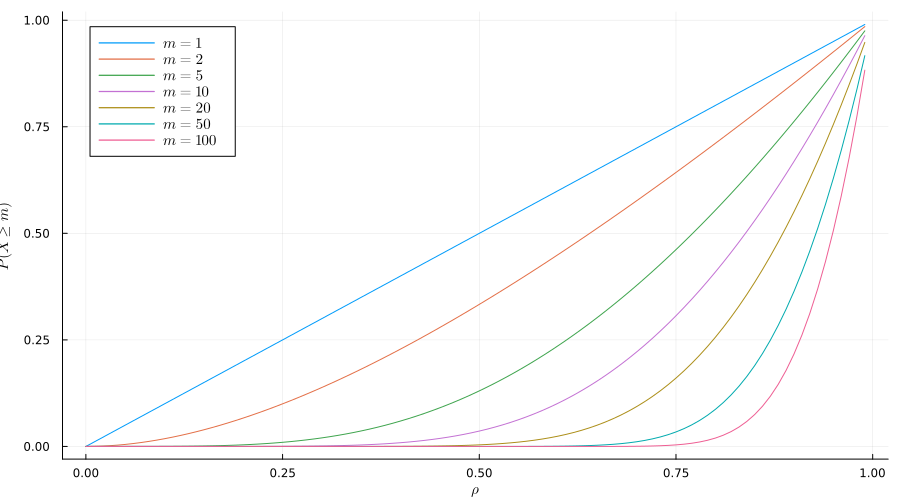

In [16]:
p=plot(xlabel=L"\rho", ylabel=L"P(X\geq m)", legend=:topleft)
M=[1,2,5,10,20,50,100]
rho=(0:.01:.99)

for m in M
    plot!(p,rho,erlangC.(rho,m), label=L"m=%$m")
end
p

## Ejercicio

Se considera un sistema de fila de espera en el cual la cantidad de servidores se adapta a la carga. En particular consideremos el siguiente modelo simplificado:

* Los trabajos llegan como un proceso de Poisson de intensidad $\lambda$.
* Todos los trabajos tienen una duración $\exp(\mu)$.
* Si hay menos de $K$ trabajos (en servicio + en espera), se mantiene un único servidor encendido.
* Si hay $K$ trabajos o más, se enciende un segundo servidor idéntico.

1. Realice un modelo de Markov para este proceso. Analice su estabilidad
2. Para el caso $\lambda=\mu=1$, calcule la distribución invariante del sistema.
3. Deduzca (analítica o numéricamente) la ocupación media del sistema y el retardo medio.
4. Investigue cuál es el *máximo* valor de $K$ que cumple que $\bar{W}<4$.
5. Simule el sistema y estudie su comportamiento empírico para validar los cálculos anteriores.